In [2]:
import ipdb

ModuleNotFoundError: No module named 'ipdb'

In [11]:
%matplotlib inline

# Data generation

## Environment and robot

Our robot is a shaped as a 2d planar box with size equals to 0.2 meters. It can move simultaneously both horizontally and vertically. Therefore, its configuration space is a 2d rectangle which size is determined by the maze size. 

In [12]:
class MyPlanarRobot():
    def __init__(self, base_xy_bounds=5.0) -> None:
        self.num_dim = 2
        self.joint_idx=[0,1]
        self.size = 0.2

        self.joint_bounds = []
        self.joint_bounds.append([-base_xy_bounds, base_xy_bounds]) # x
        self.joint_bounds.append([-base_xy_bounds, base_xy_bounds]) # y

        self.reset()

    def get_joint_bounds(self):
        return self.joint_bounds

    def get_joint_lower_bounds(self):
        robot_bounds_low = [bound[0] for bound in self.joint_bounds]
        return robot_bounds_low

    def get_joint_higher_bounds(self):
        robot_bounds_high = [bound[1] for bound in self.joint_bounds]
        return robot_bounds_high

    def get_cur_state(self):
        return self.state

    def set_state(self, state):
        self.state = state

    def reset(self):
        self.state = [0] * self.num_dim

Our environment is a 2d maze with size 5m * 5m. It is filled with random generated square obstacles of fixed size 1m * 1m.  The difficulties of the maze can be manipulated by altering the number of obstacles present. The maze can be visualized by an occupancy grid with resolution 0.5m, making it essentially an image of size 10 x 10. 

To facilitate path planning, the maze class also contains code to sample valid start and goals of the point robot and perform collision checking for a given robot configuration. 

In [13]:
import os
import sys
import numpy as np
import math
import random
import json
import sys
import os.path as osp

# -------------- Settings ----------------
RANDOM = True
TOTAL_START_GOAL_CNT = 50
MAZE_SIZE = 5
OCC_GRID_RESOLUTION = 0.1
SMALL_OCC_GRID_RESLUTION = 0.5

class Maze2D():
    def __init__(self):
        self.obstacles = []

        # load robot
        robot = MyPlanarRobot(base_xy_bounds = MAZE_SIZE / 2.0)
        self.robot = robot

        # 2d occupancy grid
        self.occ_grid_size = int(MAZE_SIZE / OCC_GRID_RESOLUTION)
        self.occ_grid = np.zeros((self.occ_grid_size, self.occ_grid_size), dtype=np.uint8)
        self.small_occ_grid_size = int(MAZE_SIZE / SMALL_OCC_GRID_RESLUTION)

        # clear obstacles
        self.clear_obstacles()

        # add surrounding walls
        half_size = MAZE_SIZE / 2.0
        # add wall
        self.add_box([half_size + 0.1, 0, 1], [0.1, half_size, 1])
        self.add_box([-half_size - 0.1, 0, 1], [0.1, half_size, 1])
        self.add_box([0, half_size + 0.1, 1], [half_size, 0.1, 1])
        self.add_box([0, -half_size - 0.1, 1], [half_size, 0.1, 1])

        # internal attributes
        self.goal_robot_id = None
        self.path = None
        self.approx_path = None
        self.sg_pairs = None

    def clear_obstacles(self):
        self.occ_grid.fill(0)
        self.obstacle_dict = {}
        self.inflated_occ_grid = None

    def random_obstacles(self, num_of_boxes = 8):
        # add random obstacles with boxes.
        # box_positions = [(-2.25, 2.25)]
        box_positions = []

        for _ in range(num_of_boxes):
            x = random.randint(0, 4)
            y = random.randint(0, 4)
            x = x - 2
            y = y - 2
            box_positions.append((x, y))

        # print(box_positions)
        for box_pos in box_positions:
            self.add_box([box_pos[0], box_pos[1], 0.5], [0.5, 0.5, 0.5])

        self.obstacle_dict["box"] = box_positions

        self.get_inflated_occ_grid()

    def add_box(self, box_pos, half_box_size):
        # for occupancy grid, center is at upper left corner, unit is cm
        half_size = MAZE_SIZE / 2.0
        tmp = int(1 / OCC_GRID_RESOLUTION)
        cx = (-box_pos[1] + half_size) * tmp
        cy = (box_pos[0] + half_size) * tmp
        x_size = half_box_size[1] * tmp
        y_size = half_box_size[0] * tmp
        for x in range(max(0, int(cx - x_size)), min(self.occ_grid_size, int(cx + x_size))):
            for y in range(max(0, int(cy - y_size)), min(self.occ_grid_size, int(cy + y_size))):
                self.occ_grid[x, y] = 1

    def get_occupancy_grid(self):
        return self.occ_grid

    def get_small_occupancy_grid(self):
        occ_grid_small = np.zeros((self.small_occ_grid_size, self.small_occ_grid_size), dtype=np.int8)
        for i in range(self.small_occ_grid_size):
            for j in range(self.small_occ_grid_size):
                occ_grid_small[i, j] = (np.max(self.occ_grid[i*5:(i+1)*5, j*5:(j+1)*5]) == 1)

        return occ_grid_small

    def get_obstacle_dict(self):
        return self.obstacle_dict.copy()

    def load_obstacle_dict(self, obstacle_dict):
        if "box" in obstacle_dict:
            for box_pos in obstacle_dict["box"]:
                self.add_box([box_pos[0], box_pos[1], 0.5], [0.5, 0.5, 0.5])

        self.obstacle_dict = obstacle_dict

    def sample_start_goal(self):
        while True:
            start = [0] * self.robot.num_dim
            goal = [0] * self.robot.num_dim
            low_bounds = self.robot.get_joint_lower_bounds()
            high_bounds = self.robot.get_joint_higher_bounds()
            for i in range(self.robot.num_dim):
                start[i] = random.uniform(low_bounds[i], high_bounds[i])
                goal[i] = random.uniform(low_bounds[i], high_bounds[i])

            if self.is_state_valid(start) and self.is_state_valid(goal):
                self.start = start
                self.goal = goal
                break

        print("Maze2d: start: {}".format(self.start))
        print("Maze2d: goal: {}".format(self.goal))

    def get_inflated_occ_grid(self):
        if self.inflated_occ_grid is None:
            tmp = np.zeros((self.occ_grid_size + 2, self.occ_grid_size + 2), dtype=np.uint8)
            tmp[:self.occ_grid_size, :self.occ_grid_size] += self.occ_grid
            tmp[1:self.occ_grid_size + 1, :self.occ_grid_size] += self.occ_grid
            tmp[2:, :self.occ_grid_size] += self.occ_grid
            tmp[:self.occ_grid_size, 1:self.occ_grid_size+1] += self.occ_grid
            tmp[1:self.occ_grid_size + 1, 1:self.occ_grid_size+1] += self.occ_grid
            tmp[2:, 1:self.occ_grid_size+1] += self.occ_grid
            tmp[:self.occ_grid_size, 2:] += self.occ_grid
            tmp[1:self.occ_grid_size + 1, 2:] += self.occ_grid
            tmp[2:, 2:] += self.occ_grid
            tmp[tmp > 0] = 1

            self.inflated_occ_grid = tmp[1:self.occ_grid_size + 1, 1:self.occ_grid_size + 1]

    def is_state_valid(self, robot_state):
        # Inflate obstacle for collision checking
        self.get_inflated_occ_grid()

        y, x = robot_state[0], robot_state[1]
        x = int((MAZE_SIZE / 2.0 - x) / 0.1)
        y = int((y + MAZE_SIZE / 2.0) / 0.1)

        res = (self.inflated_occ_grid[x, y] != 1)
        return res

Let's generate a random environment and sample a random start and goal configuration of the robot and visualize the problem. The start configuration is shown in yellow and the goal configuration is shown in red.

Maze2d: start: [-1.7337804889263038, 0.6677984352276205]
Maze2d: goal: [-2.0924252128314027, -2.0845208967241207]


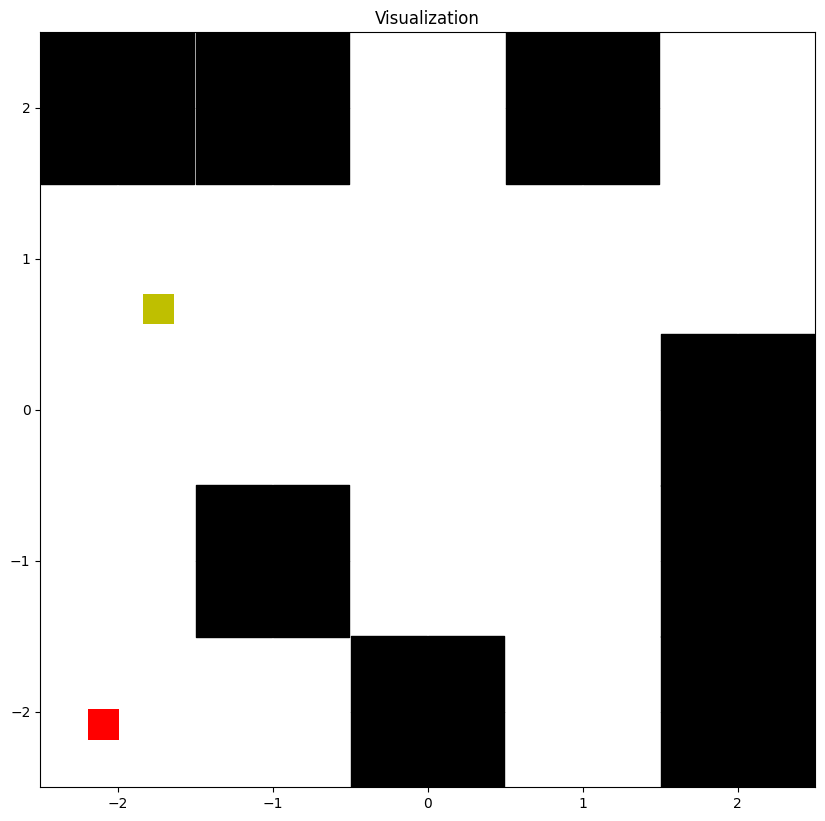

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_data(occ_g, start_pos, goal_pos):
    occ_g = np.array(occ_g).reshape(10, 10)
    fig, ax = plt.subplots(1, figsize=(10, 10), dpi=100)
    occ_grid_size = occ_g.shape[0]
    tmp = occ_grid_size / 4.0 - 0.25
    s = (10.0 / occ_grid_size * 100 / 2) ** 2 + 500
    for i in range(occ_grid_size):
        for j in range(occ_grid_size):
            if occ_g[i,j] == 1:
                plt.scatter(j/2.0 - tmp, tmp - i/2.0, color="black", marker='s', s=s, alpha=1) # init

    ax.add_patch(patches.Rectangle((start_pos[0]-0.1, start_pos[1]-0.1), 0.2, 0.2, facecolor='y'))
    ax.add_patch(patches.Rectangle((goal_pos[0]-0.1, goal_pos[1]-0.1), 0.2, 0.2, facecolor='r'))
                
    ax.set_title("Visualization")
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)

maze = Maze2D()
maze.random_obstacles()
maze.sample_start_goal()

occ_grid = maze.get_small_occupancy_grid()
visualize_data(occ_grid, maze.start, maze.goal)

## Generate Data from Expert Path Planner

To train a neural path planner, we need to generate a database of path planned by an expert path planner. There are numerous choices of path planners we can use. In this particular case, since our robot state is continuous, we choose to use the classic PRM motion planner. It firstly samples valid configurations of robot uniformly in the whole space and attempts to connect those configurations if the path between the states are collision-free. It results in a dense roadmap that captures the connectivity of the space. Finally, a discrete motion planner such as A* is used to find a path between a given start and goal configurations in the space. Another reason that PRM is particularly useful here is that it is multi-query planner, meaning the generated roadmap can be used to solve multiple queries of different start and goal configurations. 

To generate our path dataset, we sample 200 different mazes with number of obstacles ranging from 5 to 14. In each environment, we sample 500 random configurations and attempt to connect all valid configurations. We save the resultant roadmap as a networkx graph. 

### Generate Environments

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import itertools
import random

maze = Maze2D()

env_num = 200

sparse_num = 100
dense_num = 500

for i in range(env_num):
    # save
    directory = osp.join("./dataset/{}".format(i))
    if not osp.exists(directory):
        os.makedirs(directory)

    num_of_boxes = 5 + i // 50

    # env
    maze.clear_obstacles()
    maze.random_obstacles(num_of_boxes=num_of_boxes)
    occ_grid = np.array(maze.get_occupancy_grid()).reshape(50, 50)
    occ_grid_small = maze.get_small_occupancy_grid()
    obstacle_dict = maze.get_obstacle_dict()
    maze.sample_start_goal()
    maze.robot.set_state(maze.start)

    # dense states
    states = []
    col_status = []
    low = maze.robot.get_joint_lower_bounds()
    high = maze.robot.get_joint_higher_bounds()
    for _ in range(dense_num):
        random_state = [0] * maze.robot.num_dim
        for i in range(maze.robot.num_dim):
            random_state[i] = random.uniform(low[i], high[i])
        col_status.append(maze.is_state_valid(random_state)) # mark collision states
        states.append(random_state)

    dense_G = nx.DiGraph()
    dense_G.add_nodes_from([("n{}".format(i), {"coords": ','.join(map(str, state)), "col": not col_status[i]}) for i, state in enumerate(states)])

    # save
    # node_pos = np.array(states)
    node_pos = np.array([utils.state_to_numpy(dense_G.nodes[node]['coords']) for node in dense_G.nodes()])
    utils.visualize_nodes(occ_grid_small, node_pos, None, None, show=False, save=True, file_name=osp.join(directory, "dense.png"))
    node_pos = np.array([utils.state_to_numpy(dense_G.nodes[node]['coords']) for node in dense_G.nodes() if not dense_G.nodes[node]['col']])
    utils.visualize_nodes(occ_grid_small, node_pos, None, None, show=False, save=True, file_name=osp.join(directory, "dense_free.png"))

    print("connecting dense graph")
    nodes = dense_G.nodes()
    node_pairs = itertools.combinations(nodes, 2)
    # print(list(node_pairs))
    for node_pair in node_pairs:
        if not dense_G.has_edge(node_pair[0], node_pair[1]):
            s1 = dense_G.nodes[node_pair[0]]['coords']
            s2 = dense_G.nodes[node_pair[1]]['coords']
            if utils.is_edge_free(maze, s1, s2):
                dense_G.add_edge(node_pair[0], node_pair[1])
                dense_G.add_edge(node_pair[1], node_pair[0])
    for u,v in dense_G.edges:
        dense_G[u][v]['weight'] = utils.calc_weight_states(dense_G.nodes[u]['coords'], dense_G.nodes[v]['coords'])

    # save
    nx.write_graphml(dense_G, osp.join(directory, "dense_g.graphml"))
    with open(osp.join(directory, "occ_grid.txt"), 'w') as f:
        np.savetxt(f, occ_grid_small.reshape(1, -1))
    with open(osp.join(directory, "obstacle_dict.json"), 'w') as f:
        json.dump(obstacle_dict, f)
    utils.visualize_nodes(occ_grid_small, [], None, None, show=False, save=True, file_name=osp.join(directory, "occ_grid.png"))

### Generata Path

We want to collect multiple paths from a single generated environment. Therefore, we first load the saved roadmap graph, and subsequently nvoke Astar path planner to find shortest path between each possible pair of start and goal configurations. If a path is found, we add to our dataset.

Here we ignore path that contains only 2 waypoints. Intuitively, a path with two waypoints means that the start configuration and goal configuration of the robot can be connected by a straigh line. As our environment is not very cluttered, the majority of the path in our dataset may constitute such a straight-line path. This imbalance might incur problems in the latter training stage. 

In [17]:
import os.path as osp
import sys
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import random
import utils

import astar

maze = Maze2D()

env_num = 200
sample_num = 500

dataset = []
for i in range(env_num):
    print("generating paths in env {}".format(i))
    maze.clear_obstacles()

    data_dir = "./dataset/{}".format(i)
    with open(osp.join(data_dir, "obstacle_dict.json"), 'r') as f:
        obstacle_dict = json.load(f)
        maze.load_obstacle_dict(obstacle_dict)

    dense_G = nx.read_graphml(osp.join(data_dir, "dense_g.graphml"))
    occ_grid = np.loadtxt(osp.join(data_dir, "occ_grid.txt")).tolist()

    # sample trajectories
    for start_n in dense_G.nodes():
        if dense_G.nodes[start_n]['col']:
            continue

        for goal_n in dense_G.nodes():
            if dense_G.nodes[goal_n]['col']:
                continue

        goal_pos = utils.state_to_numpy(dense_G.nodes[goal_n]['coords']).tolist()
        path_nodes, dis = astar.astar(dense_G, start_n, goal_n, occ_grid, None, None, None)

        # sanity check
        total_dist = 0
        if len(path_nodes) > 2:
            for i, node in enumerate(path_nodes):
                if i < len(path_nodes) - 1:
                    start_pos = utils.state_to_numpy(dense_G.nodes[node]['coords']).tolist()
                    next_pos = utils.state_to_numpy(dense_G.nodes[path_nodes[i + 1]]['coords']).tolist()
                    dist = utils.calc_weight_states(start_pos, next_pos)
                    total_dist += dist
            # print(total_dist, dis)
            assert np.allclose(total_dist, dis)

        if len(path_nodes) > 2:
            path = []
            for i, node in enumerate(path_nodes):
                node_pos = utils.state_to_numpy(dense_G.nodes[node]['coords']).tolist()
                path.append(node_pos)

            dataset.append([start_pos, goal_pos, occ_grid, path])

with open("./dataset/data_path.json", 'w') as f:
    json.dump(dataset, f)

generating paths in env 0


KeyboardInterrupt: 

## Data Processing

Our dataset contains a paths, a sequence of waypoints. However, our MLP and CNN models predicts only the next waypoints given the current robot configuration. Therefore, the dataset needs to be further processed so that a single training data gives the next waypoint.

In [ ]:
with open('./dataset/data_path.json', 'r') as _file:
    data_path = json.load(_file)

dataset_waypoint = []
for data_point in data_path:
    start_pos, goal_pos, occ_grid, path = data_point
    for i in range(1, len(path)):
        prev_pos = path[i - 1]
        current_pos = path[i]
        dataset_waypoint.append([prev_pos, goal_pos, occ_grid, current_pos])

with open("./dataset/data_waypoint.json", 'w') as f:
    json.dump(dataset_waypoint, f)

# Visualization of the generated data

In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
DATA_FILE_PATH_TO_LOAD = './dataset/data_waypoints.json'
RAW_DATA = None

In [2]:
def visualize_data(occ_g, start_pos, goal_pos, path, predicted_path=None):
    occ_g = np.array(occ_g).reshape(10, 10)
    fig, ax = plt.subplots(1, figsize=(10, 10), dpi=100)
    occ_grid_size = occ_g.shape[0]
    tmp = occ_grid_size / 4.0 - 0.25
    s = (10.0 / occ_grid_size * 100 / 2) ** 2 + 500
    for i in range(occ_grid_size):
        for j in range(occ_grid_size):
            if occ_g[i,j] == 1:
                plt.scatter(j/2.0 - tmp, tmp - i/2.0, color="black", marker='s', s=s, alpha=1) # init

    ax.add_patch(patches.Rectangle((start_pos[0]-0.1, start_pos[1]-0.1), 0.2, 0.2, facecolor='y'))
    ax.add_patch(patches.Rectangle((goal_pos[0]-0.1, goal_pos[1]-0.1), 0.2, 0.2, facecolor='r'))
    for i, next_pos in enumerate(path):
        ax.text(next_pos[0]+0.06, next_pos[1]+0.06, str(i), {'color': 'g', 'size': 'large'})
        ax.add_patch(patches.Rectangle((next_pos[0]-0.07, next_pos[1]-0.07), 0.14, 0.14, facecolor='g'))
    if predicted_path is not None:
        for i, predicted_pos in enumerate(predicted_path):
            ax.text(predicted_pos[0] - 0.11, predicted_pos[1] - 0.11, str(i), {'color': 'b', 'size': 'large'})
            ax.add_patch(patches.Rectangle((predicted_pos[0]-0.05, predicted_pos[1]-0.05), 0.1, 0.1, facecolor='b'))

    ax.set_title("Visualization")
    ax.set_xlim(-2.5,2.5)
    ax.set_ylim(-2.5,2.5)

In [3]:
if RAW_DATA is None:
    with open(DATA_FILE_PATH_TO_LOAD) as _file:
        RAW_DATA = json.load(_file)

Randomly visualze a single data point.

- Black: obstacles
- Red: goal position
- Yellow: current position
- Green: the next position the robot should take

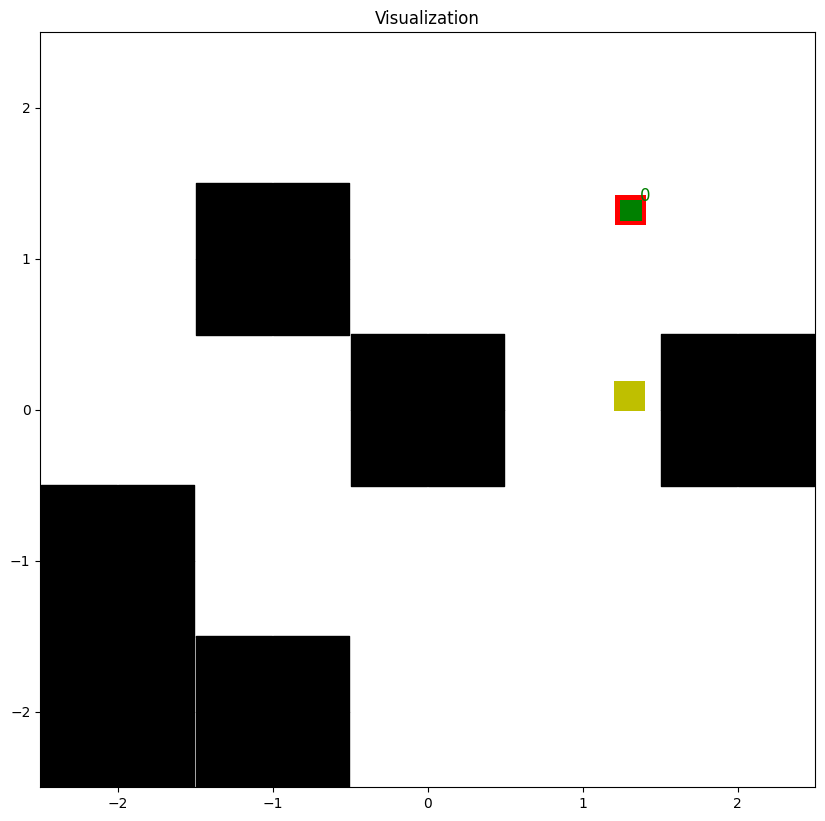

In [4]:
idx = np.random.randint(len(RAW_DATA))
current_pos, goal_pos, occ_grid, next_pos = RAW_DATA[idx]
visualize_data(occ_grid, current_pos, goal_pos, [next_pos])

# Training

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Definitions of networks and dataloaders

### MLP

In [8]:
class MLPDataset(Dataset):
    """A dataset class for the MLP.
    
    Input: A vector that concat current position, goal position and occupancy grid vector
    Output: Next position
    """
    def __init__(self, raw_data, transform=None, target_transform=None, device="cpu"):
        self.transform = transform
        self.target_transform = target_transform
        self.device = device
        self.dataset = raw_data
        print("dataset size = {}".format(len(self.dataset)))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        start_pos, goal_pos, occ_grid, next_pos = self.dataset[idx]

        dim = len(start_pos)
        start_pos = torch.Tensor(start_pos)
        goal_pos = torch.Tensor(goal_pos)
        occ_grid = torch.Tensor(occ_grid)
        next_pos = torch.Tensor(next_pos)

        input = torch.cat((start_pos, goal_pos, occ_grid), dim=0).to(self.device)
        next_pos = next_pos.to(self.device)

        return input, next_pos

    @classmethod
    def load_dataset_from_file(cls, file_path, device='cpu'):
        print("Loading data from {}".format(file_path))
        with open(file_path, 'r') as f:
            dataset = json.load(f)
        return cls(dataset, device=device)

In [9]:
class MLPModel(nn.Module):
    """A trivially simple MLP model."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        self.layers = nn.Sequential(
            nn.Linear(104, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, inputs):
        return self.layers(inputs)

## Training loop

Choose the network and dataloader classes

In [10]:
dataset_cls = MLPDataset
network_cls = MLPModel
criterion = torch.nn.MSELoss()
model_save_path = './models/mlp.pt'

Load the data

In [11]:
dataset = dataset_cls(RAW_DATA, device=DEVICE)

dataset size = 68957


Initialize the model

In [13]:
model = MLPModel().to(DEVICE)

Run the training loop

In [14]:
train_size = int(len(dataset) * 0.9)
batch_size = 64
learning_rate = 1e-4
num_epochs=10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
train_set = torch.utils.data.Subset(dataset, np.arange(train_size))
val_set = torch.utils.data.Subset(dataset, np.arange(train_size, len(dataset)))
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(val_set, batch_size=1)

In [16]:
torch.autograd.set_detect_anomaly(True)

# Run the training loop
i = 0
for epoch in range(num_epochs):
    model.train()
    for data in train_dataloader:
        # Get batch of data
        inputs, labels = data
        # Zero the gradients
        optimizer.zero_grad()
        # Perform forward pass
        network_output = model.forward(inputs)
        # Compute loss
        loss = criterion(network_output, labels)
        # Ensure no funny numerics
        assert not torch.isnan(loss).any()
        # Perform backward pass
        loss.backward()
        # 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
        # Perform optimization
        optimizer.step()
        # Print statistics
        current_loss = loss.item()
        if i % 100 == 0:
            print('-----------------Total loss after mini-batch %5d, epoch %d : %.3f' % (i, epoch, current_loss))
            current_loss = 0.0
        if i % 500 == 0:
            torch.save(model.state_dict(), model_save_path)
            print("saved session to ", model_save_path)

        i+=1

    if epoch % 5 == 0:
        # eval
        model.eval()
        total_loss = 0

        for data in eval_dataloader:
            # Get batch of data
            inputs, labels = data
            # Perform forward pass
            network_output = model.forward(inputs)
            # Compute loss
            loss = criterion(network_output, labels)
            total_loss += loss.detach().item()

        print("Evaluation----")
        print('-----------------Total loss after epoch %5d: %.3f' % (epoch, total_loss / len(eval_dataloader)))

-----------------Total loss after mini-batch     0, epoch 0 : 1.511
saved session to  ./models/mlp.pt
-----------------Total loss after mini-batch   100, epoch 0 : 0.264
-----------------Total loss after mini-batch   200, epoch 0 : 0.332
-----------------Total loss after mini-batch   300, epoch 0 : 0.259
-----------------Total loss after mini-batch   400, epoch 0 : 0.364
-----------------Total loss after mini-batch   500, epoch 0 : 0.418
saved session to  ./models/mlp.pt
-----------------Total loss after mini-batch   600, epoch 0 : 0.262
-----------------Total loss after mini-batch   700, epoch 0 : 0.210
-----------------Total loss after mini-batch   800, epoch 0 : 0.190
-----------------Total loss after mini-batch   900, epoch 0 : 0.245
Evaluation----
-----------------Total loss after epoch     0: 0.532
-----------------Total loss after mini-batch  1000, epoch 1 : 0.218
saved session to  ./models/mlp.pt
-----------------Total loss after mini-batch  1100, epoch 1 : 0.224
--------------

## Visualize the prediction

In [13]:
model = network_cls()
model.load_state_dict(torch.load(model_save_path))
model.to(DEVICE)
model.eval()

MLPModel(
  (layers): Sequential(
    (0): Linear(in_features=104, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=64, bias=True)
    (10): ReLU()
    (11): Linear(in_features=64, out_features=2, bias=True)
  )
)

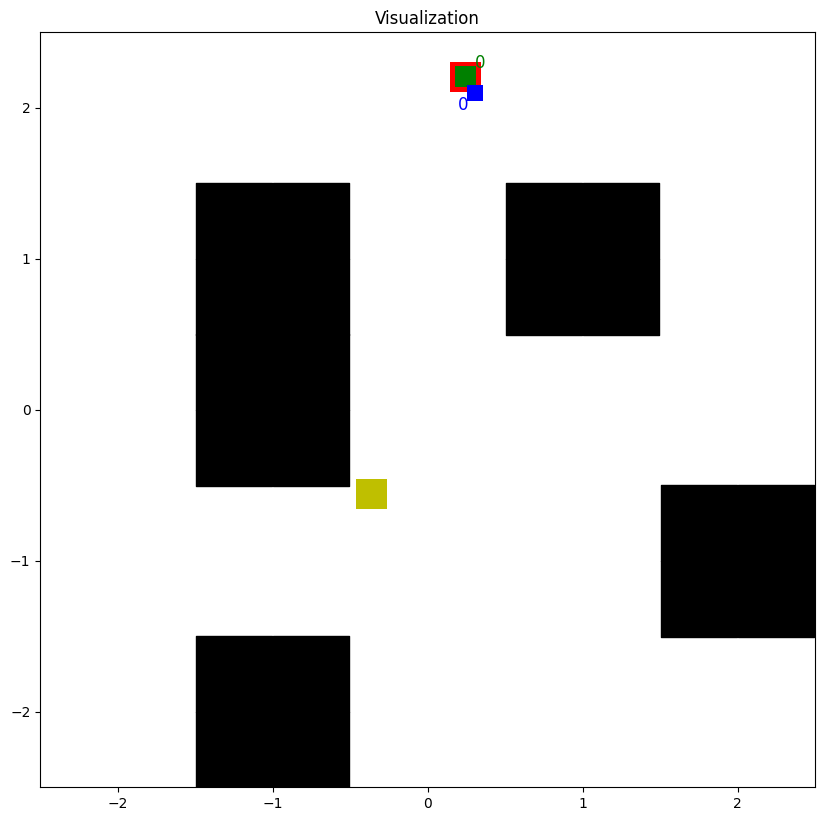

In [14]:
# TODO: only try validation set
idx = np.random.randint(len(RAW_DATA))
current_pos, goal_pos, occ_grid, next_pos = RAW_DATA[idx]
predicted_pos = model.forward(dataset[idx][0].view(1, -1)).detach().cpu().numpy().flatten()
visualize_data(occ_grid, current_pos, goal_pos, [next_pos], predicted_path=[predicted_pos])

# Motion planning test

Test dataset (100 sets):
- Obstacles
- Start
- Goal
- Path of astar

Evaluation metric:
- Sucess: close to the goal within a tolerance, path not in collision
- Path length: 

In [5]:
with open('./dataset/data_path.json') as _file:
    PATHS_DATA = json.load(_file)

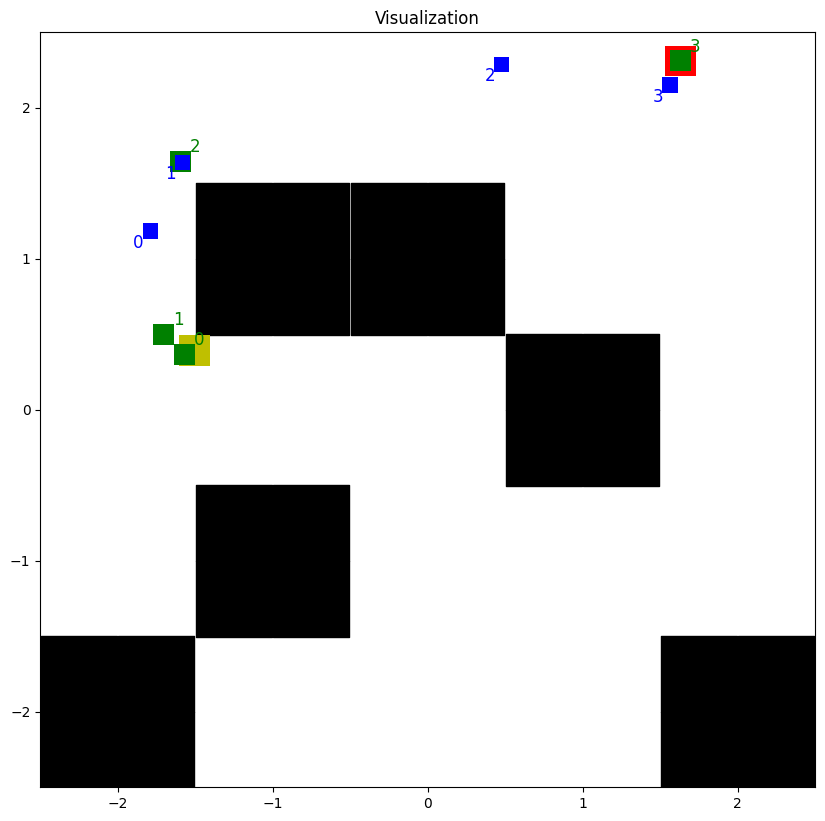

In [69]:
idx = np.random.randint(len(PATHS_DATA))
_, goal_pos_raw, occ_grid_raw, path = PATHS_DATA[idx]

goal_pos_np = np.array(goal_pos_raw)
current_pos = torch.Tensor(path[0]).to(DEVICE)
goal_pos = torch.Tensor(goal_pos_raw).to(DEVICE)
occ_grid = torch.Tensor(occ_grid_raw).to(DEVICE)
it = 0
predicted_path = []
while np.linalg.norm(current_pos.detach().cpu().numpy().flatten() - goal_pos_np) > 0.2:
    if it > 50:
        print("Haven't reached goal after 50 iterations!")
        break
    state = torch.cat((current_pos, goal_pos, occ_grid), dim=0).to(DEVICE)
    current_pos = model.forward(state.view(1, -1)).detach()[0]
    predicted_path.append(current_pos.detach().cpu().numpy().flatten())
    it += 1
    
visualize_data(occ_grid_raw, path[0], goal_pos_raw, path[1:], predicted_path)